# Build and test some models

In [78]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import seaborn as sns
#import psycopg2
import sql_utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn import metrics
from sklearn import preprocessing
import pickle
%matplotlib inline

## Pull the data from postgres

In [3]:
# select and join the BART and weather data
# select and join the BART and weather data from postgres
bart_weather_df = sql_utils.pg2pd_join(table1='bart_entry_exit', table2='weather',
                           on1='bart_entry_exit.date', on2='weather.datestamp')

In [4]:
bart_weather_df.head()

,id,date,hour,direction,station,entries,exits,day,month,id,datestamp,mean_temperature,max_temperature,min_temperature,precipitation,rain
0,0,2011-01-01,0,northbound,12TH,16,102,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
1,1,2011-01-01,0,northbound,16TH,168,26,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
2,2,2011-01-01,0,northbound,19TH,19,91,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
3,3,2011-01-01,0,northbound,24TH,72,32,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1
4,4,2011-01-01,0,northbound,BALB,72,5,Saturday,1,0,2011-01-01,43.0,45.0,40.0,0.36,1


In [6]:
# remove the redundant 'id' and 'datestamp' columns
bart_weather_df.drop(labels=['id', 'datestamp'], axis=1, inplace=True)
bart_weather_df.head()

,date,hour,direction,station,entries,exits,day,month,mean_temperature,max_temperature,min_temperature,precipitation,rain
0,2011-01-01,0,northbound,12TH,16,102,Saturday,1,43.0,45.0,40.0,0.36,1
1,2011-01-01,0,northbound,16TH,168,26,Saturday,1,43.0,45.0,40.0,0.36,1
2,2011-01-01,0,northbound,19TH,19,91,Saturday,1,43.0,45.0,40.0,0.36,1
3,2011-01-01,0,northbound,24TH,72,32,Saturday,1,43.0,45.0,40.0,0.36,1
4,2011-01-01,0,northbound,BALB,72,5,Saturday,1,43.0,45.0,40.0,0.36,1


-------
## Regression Model
Train regression models to predict crowd levels using the above features. 

### Least-squares regression
First, use a simple *ordinary least-squares (OLS) regression* model

### Partition data for validation
Partition into 80% training set and 20% test set. 

In [9]:
bart_weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2126069 entries, 0 to 2126068
Data columns (total 13 columns):
date                object
hour                object
direction           object
station             object
entries             int64
exits               int64
day                 object
month               object
mean_temperature    float64
max_temperature     float64
min_temperature     float64
precipitation       float64
rain                int64
dtypes: float64(4), int64(3), object(6)
memory usage: 210.9+ MB


In [48]:
model_data = bart_weather_df[['hour', 'direction', 'station', 'entries', 
                              'day','month', 'mean_temperature', 'rain']]
# remove NaN from data before training
model_data = model_data.loc[(~model_data.isnull().any(axis=1)), :]

In [49]:
# transform categorical features into binary dummy variables
model_data_binary = pd.get_dummies(model_data)

In [51]:
model_data_binary.head()

,entries,mean_temperature,rain,hour_0,hour_1,hour_10,hour_11,hour_12,hour_13,hour_14,...,month_11,month_12,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9
0,16,43.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,168,43.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,19,43.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,72,43.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,72,43.0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [94]:
X = model_data_binary.drop('entries', axis=1) # features = all columns except 'entries'
y = model_data_binary['entries']

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

### Train model
Fit an OLS regression model to the training data

In [57]:
lm = LinearRegression()
lm.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

### Evaluate model predictions

In [96]:
figpath = '/Users/bkhurley/git/insight/project/beat_the_crowd/figures/'

In [58]:
predictions = lm.predict(X_test)

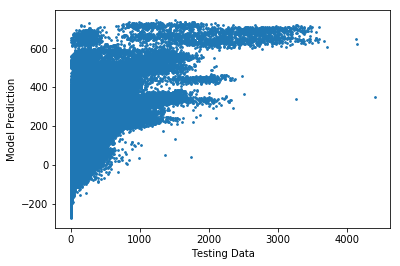

In [97]:
plt.scatter(y_test, predictions, s=3)
plt.xlabel('Testing Data')
plt.ylabel('Model Prediction')
plt.savefig(figpath + 'ols_predict.png')

### Evaluate model

In [60]:
print('RSS: ', sum((y_test - predictions)**2))
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))
print('R^2: ', metrics.r2_score(y_test, predictions))

RSS:  14541248040.023085
MAE: 154.888847273
MSE: 68394.9636654
RMSE: 261.524307982
R^2:  0.290262077905


#### Residuals

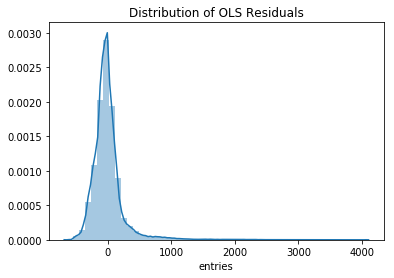

In [98]:
sns.distplot((y_test-predictions),bins=50);
plt.title('Distribution of OLS Residuals')
plt.savefig(figpath + 'ols_resid.png')

In [95]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['OLS Coefficient'])
coeff_df

,OLS Coefficient
mean_temperature,1.032651e+00
rain,-1.348479e+00
hour_0,7.537369e+08
hour_1,7.537369e+08
hour_10,7.537370e+08
hour_11,7.537370e+08
hour_12,7.537370e+08
hour_13,7.537370e+08
hour_14,7.537371e+08
hour_15,7.537371e+08


In [79]:
# dump model to pickle file so I can pick it up in Flask
with open('lm.pkl', 'wb') as fid:
    pickle.dump(lm, fid,2) 

In [89]:
#For building feature vectors, create a dataframe with the dummy variables
feats = model_data_binary.drop('entries', axis=1)
index_dict = dict(zip(feats.columns,range(feats.shape[1])))
with open('cat.pkl', 'wb') as fid:
    pickle.dump(index_dict, fid,2) 